In [1]:
!pip install python-chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148498 sha256=502abb20052b583e477a057700794efd38868830d0219ddb1db8a8ab7c898f62
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess


In [2]:
import chess
import chess.engine
# import chess.svg

# Basic chess package commands

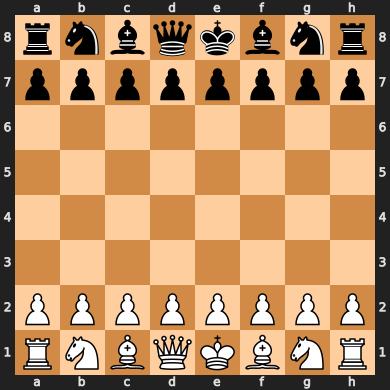

In [3]:
board = chess.Board()
board

In [4]:
# see legal moves
list(board.legal_moves)

[Move.from_uci('g1h3'),
 Move.from_uci('g1f3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1a3'),
 Move.from_uci('h2h3'),
 Move.from_uci('g2g3'),
 Move.from_uci('f2f3'),
 Move.from_uci('e2e3'),
 Move.from_uci('d2d3'),
 Move.from_uci('c2c3'),
 Move.from_uci('b2b3'),
 Move.from_uci('a2a3'),
 Move.from_uci('h2h4'),
 Move.from_uci('g2g4'),
 Move.from_uci('f2f4'),
 Move.from_uci('e2e4'),
 Move.from_uci('d2d4'),
 Move.from_uci('c2c4'),
 Move.from_uci('b2b4'),
 Move.from_uci('a2a4')]

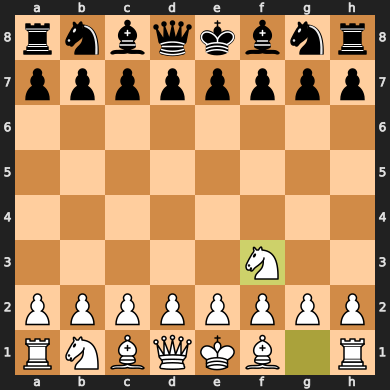

In [5]:
# make move
Nf3 = chess.Move.from_uci("g1f3")
board.push(Nf3)
board

# Evaluate board position using Stockfish

In [6]:
# from stockfish import Stockfish

# stockfish = Stockfish(path='/opt/conda/lib/python3.10/site-packages/stockfish')

In [7]:
# # find chess engine
# engine = chess.engine.SimpleEngine.popen_uci('/opt/homebrew/Cellar/stockfish/17/bin/stockfish')

# # evaluate board position
# info = engine.analyse(board, limit=chess.engine.Limit(time=1))

# engine.quit()

# Define RL agent

## State representation
How the agent 'sees' the chessboard.

In [8]:
# using the FEN (Forsyth-Edwards Notation) notation
board_fen = board.fen()
board_fen

'rnbqkbnr/pppppppp/8/8/8/5N2/PPPPPPPP/RNBQKB1R b KQkq - 1 1'

## Action space
How the agent chooses moves from the list of legal moves

In [9]:
list(board.legal_moves)

[Move.from_uci('g8h6'),
 Move.from_uci('g8f6'),
 Move.from_uci('b8c6'),
 Move.from_uci('b8a6'),
 Move.from_uci('h7h6'),
 Move.from_uci('g7g6'),
 Move.from_uci('f7f6'),
 Move.from_uci('e7e6'),
 Move.from_uci('d7d6'),
 Move.from_uci('c7c6'),
 Move.from_uci('b7b6'),
 Move.from_uci('a7a6'),
 Move.from_uci('h7h5'),
 Move.from_uci('g7g5'),
 Move.from_uci('f7f5'),
 Move.from_uci('e7e5'),
 Move.from_uci('d7d5'),
 Move.from_uci('c7c5'),
 Move.from_uci('b7b5'),
 Move.from_uci('a7a5')]

# Q-learning

## Helper functions

In [10]:
def is_game_finished(board):
    """
    Return True if the game is finished. 
    """
    if board.is_checkmate() or board.is_stalemate() or board.is_insufficient_material() or board.is_seventyfive_moves():
        return True
    else:
        return False

In [11]:
import random

def random_move(board):
    """
    Return a random legal move.
    """
    legal_moves = list(board.legal_moves) # find all legal moves
    return random.choice(legal_moves) # randomly select a move

In [12]:
def get_endgame_reward(board):
    """
    Calculate the reward for the current board state.
    Returns +1 for a win, -1 for a loss and 0 for a draw or ongoing game.
    """

    if board.is_checkmate():

        # win for the side who made the last move
        endgame_reward = 1 if board.turn==chess.BLACK else -1
    elif board.is_stalemate() or board.is_insufficient_material() or board.is_seventyfive_moves():
        # stalemate, insufficient material or if 75-move rule results in a draw
        endgame_reward = 0
    else:
        # ongoing game, no reward yet
        endgame_reward = 0
            
    return endgame_reward

In [13]:
def get_intermediate_reward(board, move):
    """
    Calculate rewards for intermediate actions, such as capturing pieces.
    """

    if board.is_capture(move):
        ### reward for capturing an opponent's piece

        captured_piece = board.piece_at(move.to_square) # find the piece at the target square
        piece_value = get_piece_value(captured_piece) # calculate piece value
        
        if board.turn == chess.WHITE: # white will capture a black piece
            return piece_value
        else: # black will capture a white piece
            return piece_value * -1
    else:
        return 0
    
def get_piece_value(piece):
    """
    Returns the value of the captured piece.
    """
    if piece.piece_type == chess.PAWN:
        return 0.1
    elif piece.piece_type == chess.KNIGHT or piece.piece_type == chess.BISHOP:
        return 0.3
    elif piece.piece_type == chess.ROOK:
        return 0.5
    elif piece.piece_type == chess.QUEEN:
        return 0.9
    else:
        return 0

# Learning algorithm

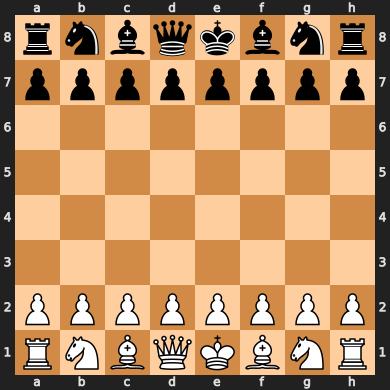

In [14]:
import numpy as np
from collections import defaultdict

# initialise/reset Q-table
q_table_white = defaultdict(float)
q_table_white

# initialise/reset Q-table
q_table_black = defaultdict(float)
q_table_black

# initialise/reset chess board
board = chess.Board()
board

In [15]:
# hyperparameters
alpha = 0.1 # learning rate
gamma = 0.9 # discount factor
epsilon = 0.2 # exploration rate

# choose move
def choose_move(board, epsilon, q_table):
    if random.uniform(0, 1) < epsilon: # explore
        print('EXPLORE')
        return random_move(board)
    else: # exploit - make the best possible move
        print('EXPLOIT')
        state = board.fen()
        legal_moves = list(board.legal_moves)
        q_values = [q_table[(state, move.uci())] for move in legal_moves] # find the q-values for all legal moves
        
        if board.turn==chess.WHITE: # if it is white's turn
            best_move = legal_moves[np.argmax(q_values)] # find the move with the highest q-value
        else: # black's turn
            best_move = legal_moves[np.argmin(q_values)] # find the move with the lowest q-value (hopefully there will be a negative one)
            
        print('Q-value:', max(q_values))
        return best_move
    
# update q-table every time the agent visits a state
def update_Q_table(state, action, reward, next_state, q_table):
    """Update the Q-value for the state-action pair using the Q-learning formula"""
    print('Legal moves:', board.legal_moves)

    # what is the most reward from the next state?
    if is_game_finished(chess.Board(next_state)):
        best_next_move = 0 # if the game has ended, there is no next move
    else:
        if board.turn==chess.WHITE: # if it is white's turn
            best_next_move = max(q_table[(next_state, move.uci())] for move in board.legal_moves) if not board.is_game_over() else 0 # if the game is continuing, find the move in the NEXT STATE with the biggest Q-value
        else: # black's turn
            best_next_move = min(q_table[(next_state, move.uci())] for move in board.legal_moves) if not board.is_game_over() else 0 # if the game is continuing, find the move in the NEXT STATE with the biggest Q-value

    # q-learning formula
    q_table[(state, action)] = q_table[(state, action)] + alpha*(reward + gamma*best_next_move - q_table[(state, action)]) # update the Q-value for the state and action

    print('Updated Q-value for state {} and action {}:'.format(state, action), q_table[(state, action)])

# Q-learning training
for episode in range(10): # number of episodes
    print('-'*10, 'EPISODE:', episode, '-'*10)
    board.reset()
    
    # initialise move variables
    move_white = None
    move_black = None
    
    while not board.is_game_over():
        
        # WHITE'S TURN
        if board.turn == chess.WHITE:
            
            state_white = board.fen() # get board state
        
            print('State:', state_white)
            
            print('Turn: WHITE')
            
            # CHOOSE ACTION
            move_white = choose_move(board, epsilon, q_table_white) # choose an action
            print('Action:', move_white)
            
            # GET REWARD
            intermediate_reward = get_intermediate_reward(board, move_white) # collect reward if there is going to be a capture
            board.push(move_white) # make the move on the board
            endgame_reward = get_endgame_reward(board) # collect reward if the there will be a checkmate
            reward_white = intermediate_reward + endgame_reward # find total reward
        
            print('Intermediate reward:', intermediate_reward)
            print('Endgame reward:', endgame_reward)

            next_black_state=board.fen() # get the next state

            print('Next state:', next_black_state)
            
            # update q-table for BLACK - only once black has made a move
            if move_black is not None:
                update_Q_table(state_black, move_black.uci(), reward_black, next_black_state, q_table_black)
        
        
        
        # BLACK'S TURN
        else:
            
            state_black = board.fen() # get board state
        
            print('State:', state_black)
            
            print('Turn: BLACK')
            
            # CHOOSE ACTION
            move_black = choose_move(board, epsilon, q_table_black) # choose an action
            print('Action:', move_black)
            
            # GET REWARD
            intermediate_reward = get_intermediate_reward(board, move_black) # collect reward if there is going to be a capture
            board.push(move_black) # make the move on the board
            endgame_reward = get_endgame_reward(board) # collect reward if the there will be a checkmate
            reward_black = intermediate_reward + endgame_reward # find total reward
        
            print('Intermediate reward:', intermediate_reward)
            print('Endgame reward:', endgame_reward)

            next_white_state=board.fen() # get the next state

            print('Next state:', next_white_state)
            
            # update q-table for WHITE
            update_Q_table(state_white, move_white.uci(), reward_white, next_white_state, q_table_white)

        # check for game over
        if board.is_game_over():
            break

---------- EPISODE: 0 ----------
State: rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1
Turn: WHITE
EXPLOIT
Q-value: 0.0
Action: g1h3
Intermediate reward: 0
Endgame reward: 0
Next state: rnbqkbnr/pppppppp/8/8/8/7N/PPPPPPPP/RNBQKB1R b KQkq - 1 1
State: rnbqkbnr/pppppppp/8/8/8/7N/PPPPPPPP/RNBQKB1R b KQkq - 1 1
Turn: BLACK
EXPLOIT
Q-value: 0.0
Action: g8h6
Intermediate reward: 0
Endgame reward: 0
Next state: rnbqkb1r/pppppppp/7n/8/8/7N/PPPPPPPP/RNBQKB1R w KQkq - 2 2
Legal moves: <LegalMoveGenerator at 0x7ed448f90b20 (Ng5, Nf4, Ng1, Rg1, Nc3, Na3, g3, f3, e3, d3, c3, b3, a3, g4, f4, e4, d4, c4, b4, a4)>
Updated Q-value for state rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1 and action g1h3: 0.0
State: rnbqkb1r/pppppppp/7n/8/8/7N/PPPPPPPP/RNBQKB1R w KQkq - 2 2
Turn: WHITE
EXPLOIT
Q-value: 0.0
Action: h3g5
Intermediate reward: 0
Endgame reward: 0
Next state: rnbqkb1r/pppppppp/7n/6N1/8/8/PPPPPPPP/RNBQKB1R b KQkq - 3 2
Legal moves: <LegalMoveGenerator at 0x7ed448f91600 (Rg8

# Evaluation

In [16]:
# get non-zero q_values
non_zero_keys = [key for key in q_table_white.keys() if q_table_white[key] > 0]
non_zero_values = [q_table_white[key] for key in non_zero_keys]
non_zeros = list(zip(non_zero_keys, non_zero_values))

In [17]:
non_zeros

[(('rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1', 'g1h3'),
  0.00013122000000000006),
 (('rnbqkb1r/pppppppp/7n/8/8/7N/PPPPPPPP/RNBQKB1R w KQkq - 2 2', 'h3g5'),
  0.0008100000000000003),
 (('rnbqkbr1/pppppppp/7n/6N1/8/8/PPPPPPPP/RNBQKB1R w KQq - 4 3', 'g5h7'),
  0.021700000000000004),
 (('rnbqkb1r/pppppppN/7n/8/8/8/PPPPPPPP/RNBQKB1R w KQq - 1 4', 'h7f8'), 0.03),
 (('r1b3q1/ppppn1kr/n4pp1/4p3/1PPP2P1/5R1P/P3PP2/RNBQKB2 w Q - 7 48', 'f3f6'),
  0.010000000000000002),
 (('r1b4q/ppppn1kr/n5p1/4p3/1PPP2P1/7P/P3PPB1/RNBQK3 w Q - 2 51', 'g2b7'),
  0.010000000000000002),
 (('r1b4q/pBppn1kr/n5p1/4p1B1/1PPP2P1/7P/P3PP2/RN1QK3 w Q - 3 53', 'b7a6'),
  0.03),
 (('r1b3q1/p1ppn1kr/B5p1/4p1B1/1PPP2P1/7P/P3PP2/RN1QK3 w Q - 1 54', 'a6c8'),
  0.03),
 (('r1B4q/p1ppn1kr/6p1/4p1B1/1PPP2P1/7P/P3PP2/RN1QK3 w Q - 1 55', 'c8d7'),
  0.010000000000000002),
 (('r6q/p1p1n1kr/6p1/4pBB1/1PPP2P1/7P/P3PP2/RN1QK3 w Q - 3 57', 'g5e7'), 0.03),
 (('6r1/2p1N1kr/p5p1/4p3/1PqP2P1/7P/P2KPP2/R2Q4 w - - 8 67', 'e7g8')

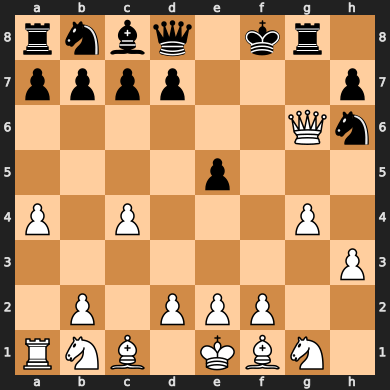

In [18]:
eval_board = chess.Board('rnbq1kr1/pppp3p/6Qn/4p3/P1P3P1/7P/1P1PPP2/RNB1KBN1 w Q - 1 15')
eval_board

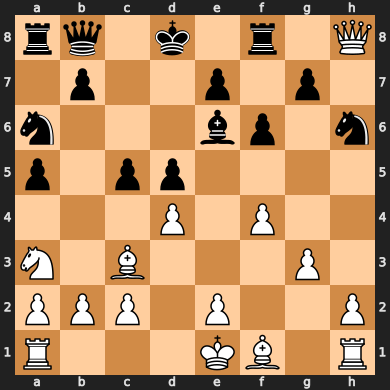

In [19]:
# State: rq1k1r1Q/1p2p1p1/n3bp1n/p1pp4/3P1P2/N1B3P1/PPP1P2P/R3KB1R b KQ - 3 47
#Turn: BLACK
#Action: f8h8
eval_board2 = chess.Board('rq1k1r1Q/1p2p1p1/n3bp1n/p1pp4/3P1P2/N1B3P1/PPP1P2P/R3KB1R b KQ - 3 47')
eval_board2